In [1]:
from torchvision import transforms
from torch.utils.data import DataLoader
import pathlib
import sys
import torchmetrics
from torchmetrics.classification import (
    MulticlassAUROC,
    MulticlassJaccardIndex,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassAccuracy,
    BinaryAccuracy,
    BinaryAUROC,
    BinaryF1Score,
    BinaryPrecision,
    BinaryRecall,
    BinaryJaccardIndex,
)
import torch
import torch.nn as nn

root = pathlib.Path().absolute().parent
DATASET_PATH = root / 'datasets'
MODEL_REGISTRY = root / 'model_registry'

sys.path.append(str(root))

from src.data.classification import TumorBinaryClassificationDataset, CLASSIFICATION_NORMALIZER
from src.utils.config import get_device
from src.enums import DataSplit
from src.models.classification.logreg import LogisiticRegression
from src.trainer import eval_classification, train_classification
from src.utils.visualize import create_classification_results

In [2]:
DIM = 256
N_EPOCHS = 15
BATCH_SIZE = 32

transform = transforms.Compose(
    [
        transforms.Resize((DIM, DIM)),  # TODO: make this larger
        transforms.ToTensor(),
        CLASSIFICATION_NORMALIZER
    ]
)

device = get_device()

LOG_REG_MODEL = MODEL_REGISTRY / 'log_reg.pth'

In [3]:
train_dataset = TumorBinaryClassificationDataset(
    root_dir=DATASET_PATH,
    split=DataSplit.TRAIN,
    transform=transform,
)

test_dataset = TumorBinaryClassificationDataset(
    root_dir=DATASET_PATH,
    split=DataSplit.TEST,
    transform=transform,
)

print("Train dataset length: ", len(train_dataset))
print("Test dataset length: ", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train dataset length:  5712
Test dataset length:  1311


In [4]:
model = LogisiticRegression(DIM * DIM * 3, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)

# train_classification(
#     model,
#     train_loader,
#     optimizer,
#     criterion,
#     device,
#     N_EPOCHS,
#     is_multiclass=False,
#     model_path=LOG_REG_MODEL
# )

Epoch 1/15:   0%|          | 0/179 [00:00<?, ?batch/s]

Epoch 1/15: 100%|██████████| 179/179 [00:15<00:00, 11.27batch/s, Avg Train Loss=0.5914362659001481, Phase=Train]


Epoch 1/15, Loss: 0.5914362659001481


Epoch 2/15: 100%|██████████| 179/179 [00:15<00:00, 11.47batch/s, Avg Train Loss=0.5917912878137728, Phase=Train]


Epoch 2/15, Loss: 0.5917912878137728


Epoch 3/15: 100%|██████████| 179/179 [00:15<00:00, 11.40batch/s, Avg Train Loss=0.5713794549417234, Phase=Train]


Epoch 3/15, Loss: 0.5713794549417234


Epoch 4/15: 100%|██████████| 179/179 [00:15<00:00, 11.82batch/s, Avg Train Loss=0.4957170326616512, Phase=Train] 


Epoch 4/15, Loss: 0.4957170326616512


Epoch 5/15: 100%|██████████| 179/179 [00:15<00:00, 11.70batch/s, Avg Train Loss=0.48816892854328253, Phase=Train]


Epoch 5/15, Loss: 0.48816892854328253


Epoch 6/15: 100%|██████████| 179/179 [00:15<00:00, 11.72batch/s, Avg Train Loss=0.4846838496250814, Phase=Train] 


Epoch 6/15, Loss: 0.4846838496250814


Epoch 7/15: 100%|██████████| 179/179 [00:15<00:00, 11.86batch/s, Avg Train Loss=0.4820954971140324, Phase=Train] 


Epoch 7/15, Loss: 0.4820954971140324


Epoch 8/15: 100%|██████████| 179/179 [00:15<00:00, 11.67batch/s, Avg Train Loss=0.4773571852532181, Phase=Train] 


Epoch 8/15, Loss: 0.4773571852532181


Epoch 9/15: 100%|██████████| 179/179 [00:15<00:00, 11.67batch/s, Avg Train Loss=0.473619336023011, Phase=Train]  


Epoch 9/15, Loss: 0.473619336023011


Epoch 10/15: 100%|██████████| 179/179 [00:15<00:00, 11.89batch/s, Avg Train Loss=0.47173588718781906, Phase=Train]


Epoch 10/15, Loss: 0.47173588718781906


Epoch 11/15: 100%|██████████| 179/179 [00:15<00:00, 11.87batch/s, Avg Train Loss=0.4695596615029448, Phase=Train] 


Epoch 11/15, Loss: 0.4695596615029448


Epoch 12/15: 100%|██████████| 179/179 [00:14<00:00, 12.01batch/s, Avg Train Loss=0.4659164036785425, Phase=Train] 


Epoch 12/15, Loss: 0.4659164036785425


Epoch 13/15: 100%|██████████| 179/179 [00:14<00:00, 11.94batch/s, Avg Train Loss=0.46523860762905156, Phase=Train]


Epoch 13/15, Loss: 0.46523860762905156


Epoch 14/15: 100%|██████████| 179/179 [00:14<00:00, 11.94batch/s, Avg Train Loss=0.4628052278603921, Phase=Train] 


Epoch 14/15, Loss: 0.4628052278603921


Epoch 15/15: 100%|██████████| 179/179 [00:15<00:00, 11.81batch/s, Avg Train Loss=0.4614648297845319, Phase=Train] 

Epoch 15/15, Loss: 0.4614648297845319


0.4614648297845319

In [7]:
model.load_state_dict(torch.load(LOG_REG_MODEL))
model.to(device)
model.eval()

metrics = torchmetrics.MetricCollection(
    [
        BinaryAUROC().to(device),
        BinaryJaccardIndex().to(device),
        BinaryAccuracy().to(device),
        BinaryF1Score().to(device),
        BinaryPrecision().to(device),
        BinaryRecall().to(device),
    ]
)

y_true, y_pred, total_metrics = eval_classification(
    model,
    test_loader,
    metrics,
    device,
    is_multiclass=False,
)

accuracy = total_metrics["BinaryAccuracy"]
print(f"Accuracy on test set: {accuracy:.2%}")

  0%|          | 0/41 [00:00<?, ?it/s]/home/jhrudd/miniconda3/envs/ai_project_env/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
 44%|████▍     | 18/41 [00:01<00:02, 11.46it/s]/home/jhrudd/miniconda3/envs/ai_project_env/lib/python3.11/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
100%|██████████| 41/41 [00:03<00:00, 12.12it/s]

Evaluation metrics: BinaryAUROC: 0.7945997714996338
BinaryJaccardIndex: 0.8097514510154724
BinaryAccuracy: 0.8482074737548828
BinaryF1Score: 0.8948758840560913
BinaryPrecision: 0.8581560254096985
BinaryRecall: 0.9348785877227783
Accuracy on test set: 84.82%


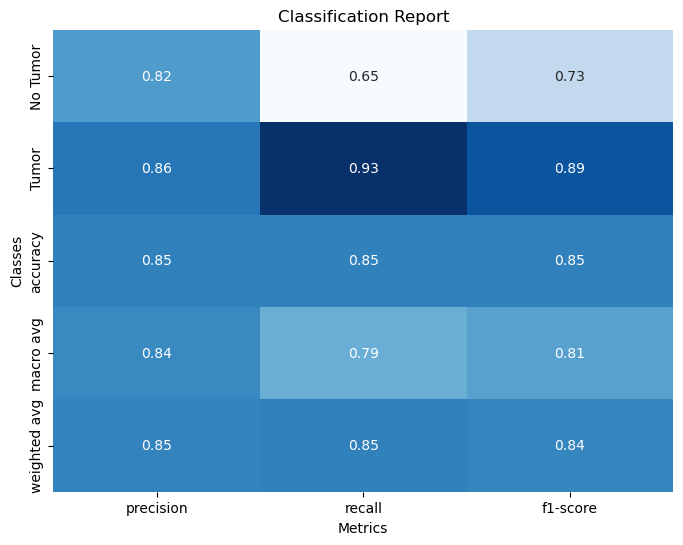

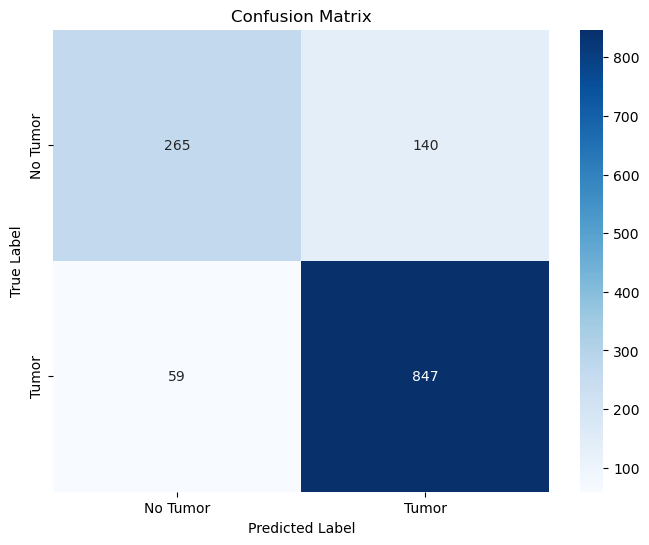

In [8]:
class_names = ["No Tumor", "Tumor"]
create_classification_results(
    y_true,
    y_pred,
    class_names,
)